In [1]:
%load_ext Cython
from numpy import linalg

In [11]:
%%cython
import numpy as np

class Particula:#En esta clase definimos los métodos fundamentales que debe seguir cada partícula

    def __init__(self, (float,float) posicion, (float,float) velocidad, float masa, float radio): 
       """comenzamos definiendo el método que debe 
        inicializar la clase, en este definimos los atributos básicos de la clase partícula
        las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats"""  
       self.radio=radio  
       self.masa=masa 
       
       self.posicion=np.array(posicion)   #Estas variables son arrays de numpy, y las trataremos como vectores
       self.velocidad=np.array(velocidad)
       self.velocidad_mag=np.linalg.norm(self.velocidad)#Este atributo no es otra cosa que la magnitud del vector velocidad
     
       """Creamos tres listas con los vectores posición y velocidad y velocidad_mag, posteriormente las usaremos
       para generar una lista con todos los valores que ha tenido la velocidad y posición"""
       
       self.velocidad_n=[self.velocidad]    ##Velocidad_n y posición_n son listas de vectores que contienen las listas correspondiente a
       self.posicion_n=[self.posicion]      ##todos los valores de estos vectores
       self.velocidad_mag_n=[self.velocidad_mag]
     
  ##########################################################################
    def paso_dt(self,float dt):   #Falta definir el valor que va a tomar dt  
       """Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula y agrega a las listas
       una actualización tanto de la posición de la partícula como la velocidad de la misma"""
      
       self.posicion=self.posicion + self.velocidad*dt  
       self.posicion_n.append(self.posicion) #Se añaden 
       self.velocidad_n.append(self.velocidad)
       self.velocidad_mag_n.append(self.velocidad_mag)
 ###############################################################################################
    def ver_colision_pp(self,otra_p):
       """Este método verifica si se dio luegar a una colisión entre dos partículas, las entradas
      son dos partículas, se definen sus radios y posiciones y se plantea una condición que indica 
      si las partículas chocaron"""
       cdef float r1=self.radio
       cdef float r2=otra_p.radio
       p1=self.posicion
       p2=otra_p.posicion
       cdef float sep=np.linalg.norm(p1-p2)#Norma del vector separación de ambas partículas.
       if sep-(r1+r2)*1.1<=0:#Si la separación es menor o igual a la suma de sus radios, entonces las partículas están en contacto y por lo tanto chocaron.
         return True
       else:
         return False
######################################################################################################
    def ver_colision_esquina(self, float Lx, float Ly):
       "Revisa si hay colisión con una esquina, Lx y Ly son las dimensiones horizontal y vertical de la caja respectivamente"
       extremo_izquierdo = self.posicion[0] - self.radio #da la posición del extremo izquido de la partícula
       extremo_inferior = self.posicion[1] - self.radio  #da la posición del extremo inferior de la partícula
       extremo_derecho  = self.posicion[0] + self.radio  #da la posición del extremo derech0 de la partícula
       extremo_superior = self.posicion[1] + self.radio  #da la posición del extremo superior de la partícula
       #Ahora construimos las variables donde se va a almacenar el hecho de chocar contra una esquina o no
       cdef bint choque_00 = extremo_izquierdo >0 and extremo_inferior> 0   #Esto corresponde a no chocar con la esquina (0,0)
       cdef bint choque_Lx0 = extremo_derecho <Lx and extremo_inferior > 0 #Esto corresponde a no chocar con la esquina (Lx,0)
       cdef bint choque_LxLy =  extremo_derecho <Lx and extremo_superior <Ly  #Esto corresponde a no chocar con la esquina (Lx,Ly)
       cdef bint choque_0Ly = extremo_izquierdo > 0 and extremo_superior <Ly  #Esto corresponde a chocar con la esquina (0,Ly)
       if not choque_00 or not choque_Lx0 or not choque_LxLy or not choque_0Ly:
         return  True 
       else:
         return False
       
        
#####################################################################################################
    def ver_colision_muro(self, float Lx, float Ly):
        """Este método revisa si la partícula ha chocado contra un muro."""
        """La condición ve que si la posición en "x" es diferente 0 o la longitud horizontal (Lx) de la caja y adicionalmente
     #  si la posición en "y" es diferente de 0 o la longitud vertical (Ly) entonces la partícula no está chocando contra un muro"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        if choque_pared_derecha and choque_pared_izquierda and choque_pared_superior and choque_pared_inferior :
          return False
        else:
          return True 
        
######################################################################################################
    def resolver_colision_particula(self,otra_p):
      """Método que actualiza las velocidades de dos partículas después de chocar
       Definimos las magnitudes a usar para resolver el choque"""
      M1=self.masa
      M2=otra_p.masa
      p1=self.posicion
      p2=otra_p.posicion
      V1=self.velocidad
      V2=otra_p.velocidad
      cdef bint choque=self.ver_colision_pp
      if choque:
        self.velocidad= self.velocidad-((2*M2)/(M1+M2))*(np.dot(p1-p2,V1-V2)/(np.linalg.norm(p1-p2)**2))*(p1-p2)#Se resuleven los choques tal cual el modelo bidimensional que se tiene
        otra_p.velocidad= otra_p.velocidad-((2*M1)/(M1+M2))*(np.dot(p2-p1,V2-V1)/(np.linalg.norm(p2-p1)**2))*(p2-p1)
  
###############################################################################################################
    def resolver_colision_muro(self,float Lx,float Ly): 
        """#Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
        partícula y las dimensiones de la caja"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        #Ahora miramos cual fue la pared con que se chocó e invertimos la coordenada teniendo en cuenta eso
        if not choque_pared_derecha or not choque_pared_izquierda:
            self.velocidad[0] = -1* self.velocidad[0]
        elif not choque_pared_superior or not choque_pared_inferior:
            self.velocidad[1] = -1* self.velocidad[1]
       
    def resolver_colision_esquina(self):
        """Método que actualiza la velocidad después de que una partícula choca con una esquina"""
        self.velocidad = -1* self.velocidad #se invierte todo el vector
            
        

In [46]:
#Simulación multiples partículas
help(plt.interactive)

Help on function interactive in module matplotlib:

interactive(b)
    Set whether to redraw after every plotting command (e.g. `.pyplot.xlabel`).



In [20]:
def listas_para_llenar(n): ###Recibe el número de partículas y crea una lista con sublistas. 
    lista_principal = []   ###Cada partícula tiene una lista que ocupa una posicion en lista_principal
    for j in range(n):     ###y a su vez estas listas tienen dos listas para almacenar la información 
        lista_principal.append([[],[]]) ###de la posición en x y y de esa partícula.
    return lista_principal
listas_para_llenar(3)

[[[], []], [[], []], [[], []]]

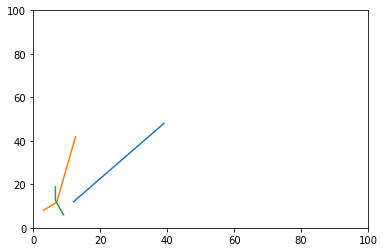

In [54]:
#Prueba de ver_colision_muro
dt = 0.1 #tamaño del paso
Lx = 100 #Tamñaño de la caja 
Ly = 100
nt = 10 #número de pasos
n = 3    #número de partículas
lista_principal = listas_para_llenar(n)
p1 =  Particula((12,12),(30,40),1,1)
p2 = Particula((3,8),(20,19),2,1)
p3 = Particula((9,6),(-12,33),2,1)
par = [p1,p2,p3]

for j in range(nt):
    for k in range(n):
        lista_principal[k][0].append(par[k].posicion[0])  #Se añade la posición en x de cada partícula
        lista_principal[k][1].append(par[k].posicion[1])  #Se añade la posicion en y de cada partícula
    for p in par:     #Revisamos las colisiones entre partículas
        for i in range(par.index(p)+1,n) :
            if p.ver_colision_pp(par[i]):
                p.resolver_colision_particula(par[i])
    
    for p in par: #Revisamos las condiciones de choque con la caja
        if p.ver_colision_muro(Lx,Ly):
            p.resolver_colision_muro(Lx,Ly)
        elif p.ver_colision_esquina(Lx,Ly):
            p.resolver_colision_esquina()
    for p in par:
        p.paso_dt(dt)

fig = plt.figure()
for k in range(n):
    plt.plot(lista_principal[k][0],lista_principal[k][1])
             # return the current xlim
plt.xlim((0, 100));  # set the xlim to left, right
plt.ylim((0, 100));   # set the xlim to left, right

In [ ]:
#Prueba de ver_colision_esquina
p1 = Particula((,),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_esquina(9,12):
    print("se paró")
    break
print(p1.posicion_n)

se paró
[array([3., 2.]), array([6., 6.]), array([ 9., 10.])]


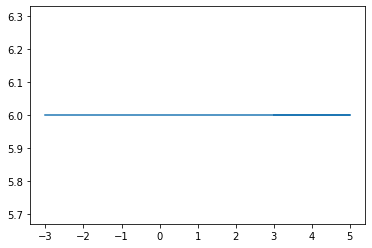

[-1.  0.]
[1. 0.]
[array([3., 6.]), array([4., 6.]), array([5., 6.]), array([4., 6.]), array([3., 6.]), array([2., 6.]), array([1., 6.]), array([0., 6.]), array([-1.,  6.]), array([-2.,  6.]), array([-3.,  6.])]
[array([9., 6.]), array([8., 6.]), array([7., 6.]), array([8., 6.]), array([9., 6.]), array([10.,  6.]), array([11.,  6.]), array([12.,  6.]), array([13.,  6.]), array([14.,  6.]), array([15.,  6.])]


In [67]:
#Prueba resolver colision con dos partículas unidimensional

p1=Particula((3,6),(1,0),2,1)
p2=Particula((9,6),(-1,0),2,1)
for j in range(10):
  p1.paso_dt(1)
  p2.paso_dt(1)
  if p1.ver_colision_pp(p2):
    p1.resolver_colision_particula(p2)

x=[]
y=[]
for n in p1.posicion_n:
  x.append(n[0])
  y.append(n[1])
plt.plot(x,y)
plt.show()
print(p1.velocidad)
print(p2.velocidad)   
print(p1.posicion_n)
print(p2.posicion_n)


[-1.  1.]
[1. 1.]
[array([0., 0.]), array([1., 1.]), array([2., 2.]), array([1., 3.]), array([0., 4.]), array([-1.,  5.]), array([-2.,  6.]), array([-3.,  7.]), array([-4.,  8.]), array([-5.,  9.]), array([-6., 10.])]


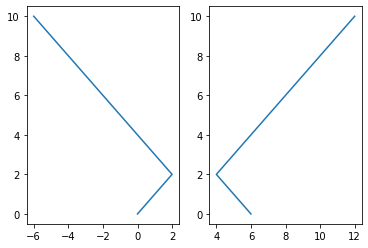

In [71]:
#Prueba resolver colision con dos partículas bidimensional
P1=Particula((0,0),(1,1),2,1)
P2=Particula((6,0),(-1,1),2,1)
for j in range(10):
  P1.paso_dt(1)
  P2.paso_dt(1)
  
  if P1.ver_colision_pp(P2):
    P1.resolver_colision_particula(P2)

x=[]
y=[]
for n in P1.posicion_n:
  x.append(n[0])
  y.append(n[1])
x1=[]
y1=[]
for n1 in P2.posicion_n:
  x1.append(n1[0])
  y1.append(n1[1])

plt.subplot(121)
plt.plot(x,y)
plt.subplot(122)
plt.plot(x1,y1)


print(P1.velocidad)
print(P2.velocidad)   
print(P1.posicion_n)



In [ ]:
#Prueba de resolver_colision_muro
p1 = Particula((0,0),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_muro(20,20):
     p1.resolver_colision_muro(20,20)
     break
print(p1.posicion)
print(p1.velocidad)

[15. 20.]
[ 3. -4.]


In [ ]:
#Prueba de resolver_colision_esquina
p1 = Particula((0,0),(3,4),1,0.5)
for j in range(10):
  p1.paso_dt(1)
  if p1.ver_colision_esquina(9,12):
     p1.resolver_colision_esquina()
     break
print(p1.posicion)
print(p1.velocidad)

[ 9. 12.]
[-3. -4.]


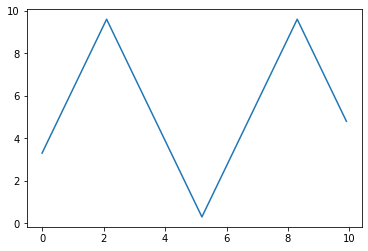

In [69]:
#Prueba de una partícula en una sola dimensión
p1 = Particula((3,3),(3,0),1,0.5)
dt = 0.1
t = [None]
x = []
y = []
for n in range(100):
    p1.paso_dt(dt)
    t.append(n*dt)
    if p1.ver_colision_muro(10,10):
        p1.resolver_colision_muro(10,10)

for p in p1.posicion_n:
    x.append(p[0])
    y.append(p[1])

plt.plot(t,x)
plt.show()
#print(p1.posicion_n)

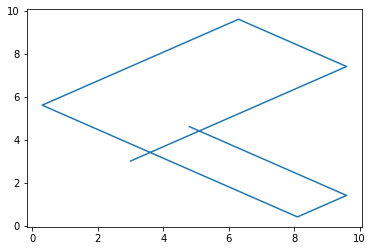

In [ ]:
#Prueba partícula en dos dimensiones 
p1 = Particula((3,3),(3,2),1,0.5)
dt = 0.1
t = [None]
x = []
y = []
for n in range(100):
    p1.paso_dt(dt)
    t.append(n*dt)
    if p1.ver_colision_muro(10,10):
        p1.resolver_colision_muro(10,10)

for p in p1.posicion_n:
    x.append(p[0])
    y.append(p[1])

plt.plot(x,y)
plt.show()
